## 進階機器學習 HW4-5
#### Develop a Python program that **accepts an image and a textual description**, and determines **whether the content of the image matches the description**. Report whether the match is valid or not.
* 學號: B103040047
* 姓名: 周安

[Reference of this colab notebooks](https://colab.research.google.com/github/openai/clip/blob/master/notebooks/Interacting_with_CLIP.ipynb)

[openai/CLIP](https://github.com/openai/CLIP)

### Final Results for testinf CIFAR100 dataset on model (ViT-L/14@336px):
Top-1 Acc = 72.06%  
Top-3 Acc = 87.74%  
Top-5 Acc = 91.83%  

# Interacting with CLIP

This is a self-contained notebook that shows how to download and run CLIP models, calculate the similarity between arbitrary image and text inputs, and perform zero-shot image classifications.

# Preparation for Colab

Make sure you're running a GPU runtime; if not, select "GPU" as the hardware accelerator in Runtime > Change Runtime Type in the menu. The next cells will install the `clip` package and its dependencies, and check if PyTorch 1.7.1 or later is installed.

In [80]:
! pip install ftfy regex tqdm
! pip install git+https://github.com/openai/CLIP.git

In [81]:
import numpy as np
import torch
from pkg_resources import packaging
import os

import skimage
import IPython.display
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np

from collections import OrderedDict
import torch
import torchvision

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
print("Torch version:", torch.__version__)


Torch version: 2.6.0+cu124


# Zero-Shot Image Classification

You can classify images using the **cosine similarity** (times 100) as the logits to the softmax operation.

Prepare all the train data.
1. torchvision.io.read_image() # return to tensor
2. transform() # for center the digit, and return PIL image
3. preprocess() # clip.preprocess the transformed result, and return tensor
4. clip.tokenize the text.
5. Encode image and text.
6. Normalize the input feature.
7. Calculate **cosine similarity**, and save in `similarity`
  
Or  
* `567.` can change into do `model(image, text)`

In [82]:
from tqdm import tqdm

def predict(image, labels):
  '''
    image: original image
    labels: list of texts: ["a photo of A", "a photo of B", ...]
  '''
  # Load and convert to RGB
  image_input = preprocess(image).unsqueeze(0).to(device)

  # Tokenize labels
  text_inputs = clip.tokenize(labels).to(device)
  # Encode
  with torch.no_grad():
    # image_features = model.encode_image(image_input).float()
    # text_features = model.encode_text(text_inputs).float()

    logits_per_image, logits_per_text = model(image_input, text_inputs)
    probs = logits_per_image.softmax(dim=-1).cpu()[0]

  top_probs, top_labels = probs.topk(5)
  return top_probs, top_labels

# Loading the model

`clip.available_models()` will list the names of available CLIP models.

|Model | Type | Params / Size | Typical Accuracy | Speed | Notes|
|--|--|--|--|--|--|
|RN50 | ResNet-50 | Medium | Decent | Fast | Good baseline model |
RN101 | ResNet-101 | Large | Better than RN50 | Slower | Deeper ResNet improves accuracy
RN50x4 | ResNet-50×4 | Huge | Much better | Slow | 4× wider, more channels
RN50x16 | ResNet-50×16 | Massive | Excellent | Very slow | 16× wider, very high accuracy
RN50x64 | ResNet-50×64 | Enormous | Best in ResNet family | Extremely slow | 64× wider
ViT-B/32 | Vision Transformer | Medium | Good | Medium | 32×32 patch size
ViT-B/16 | Vision Transformer | Large | Very good | Medium-Slow | 16×16 patch size
ViT-L/14 | Vision Transformer | Huge | Excellent | Slow | Larger model, 14×14 patch
ViT-L/14@336px | Vision Transformer | Huge | Best overall | Slow | Same as ViT-L/14 but 336×336 resolution

In [83]:
import clip

clip.available_models()

['RN50',
 'RN101',
 'RN50x4',
 'RN50x16',
 'RN50x64',
 'ViT-B/32',
 'ViT-B/16',
 'ViT-L/14',
 'ViT-L/14@336px']

In [84]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [85]:
model, preprocess = clip.load("ViT-L/14@336px", device=device)
model.cuda().eval()
input_resolution = model.visual.input_resolution
context_length = model.context_length
vocab_size = model.vocab_size

print("Model parameters:", f"{np.sum([int(np.prod(p.shape)) for p in model.parameters()]):,}")
print("Input resolution:", input_resolution)
print("Context length:", context_length)
print("Vocab size:", vocab_size)

Model parameters: 427,944,193
Input resolution: 336
Context length: 77
Vocab size: 49408


# Image Preprocessing

1. We resize the input images and center-crop them to conform with the image resolution that the model expects. Before doing so, we will normalize the pixel intensity using the dataset mean and standard deviation.

The second return value from `clip.load()` contains a torchvision `Transform` that performs this preprocessing.

2. I add my own transform ehich can move the digits to the center of the images.

3. **Use `torchvision.io.read_image` to read the image first; then, do `2.` and then do `1.`.**


In [86]:
preprocess

Compose(
    Resize(size=336, interpolation=bicubic, max_size=None, antialias=True)
    CenterCrop(size=(336, 336))
    <function _convert_image_to_rgb at 0x78858209e520>
    ToTensor()
    Normalize(mean=(0.48145466, 0.4578275, 0.40821073), std=(0.26862954, 0.26130258, 0.27577711))
)

# Text Preprocessing

We use a case-insensitive tokenizer, which can be invoked using `clip.tokenize()`. By default, the outputs are padded to become 77 tokens long, which is what the CLIP models expects.

In [87]:
test = clip.tokenize('Hello world.')
print(test.shape)
print(test)

torch.Size([1, 77])
tensor([[49406,  3306,  1002,   269, 49407,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0]], dtype=torch.int32)


# Use `CIFAR100` to test this pre-trained CLIP model.

In [88]:
import os
from torchvision.datasets import CIFAR100

# Download the dataset
cifar100 = CIFAR100(root=os.path.expanduser("~/.cache"), download=True, train=False)
len(cifar100)

10000

* List 10 text labels.

In [89]:
labels = [f"a photo of a {c}" for c in cifar100.classes]
labels[:10]

['a photo of a apple',
 'a photo of a aquarium_fish',
 'a photo of a baby',
 'a photo of a bear',
 'a photo of a beaver',
 'a photo of a bed',
 'a photo of a bee',
 'a photo of a beetle',
 'a photo of a bicycle',
 'a photo of a bottle']

In [90]:
print("Total classes:", len(cifar100.classes))

Total classes: 100


### Show 10 results visually.

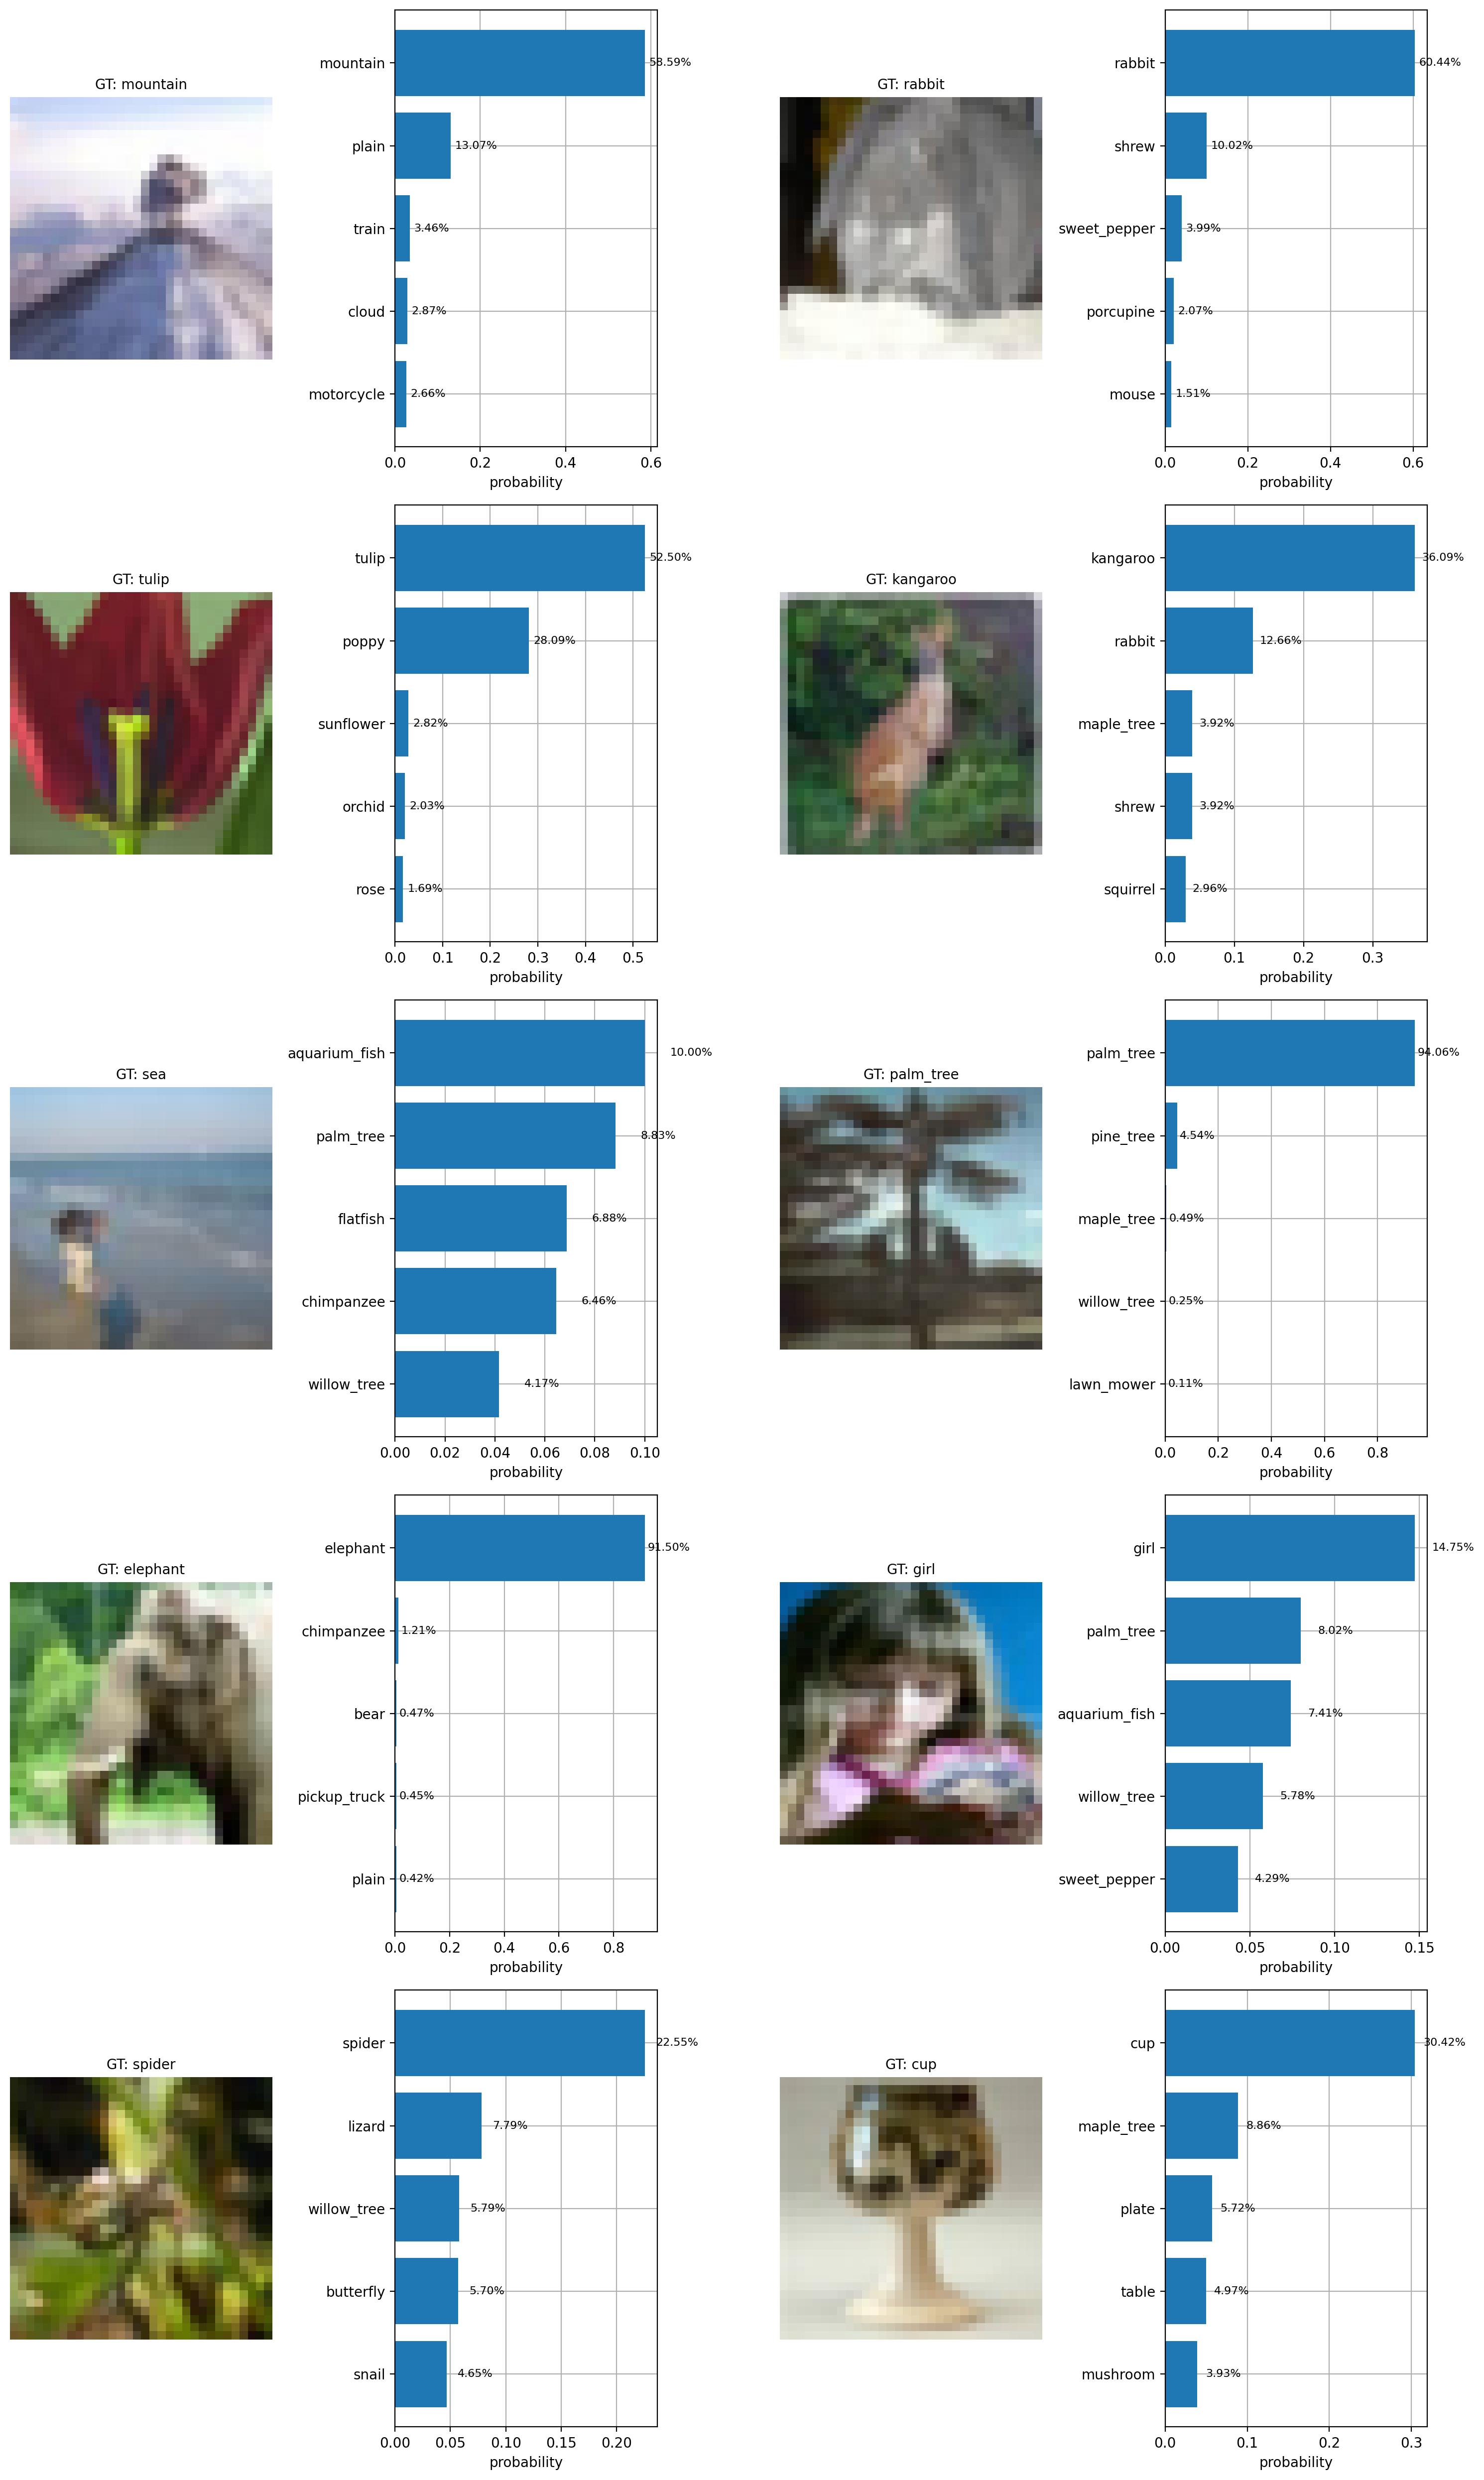

In [115]:
plt.figure(figsize=(15, 25))
for i, img_idx in enumerate(range(0, 10000, 1000)):
    image, class_id = cifar100[img_idx]

    # image subplot
    ax_img = plt.subplot(5, 4, 2 * i + 1)
    ax_img.imshow(image)
    ax_img.axis("off")
    ax_img.set_title(f"GT: {cifar100.classes[class_id]}", fontsize=10)

    # predict this image
    top_probs, top_labels = predict(image, labels)
    # bar chart subplot
    ax_bar = plt.subplot(5, 4, 2 * i + 2)
    y = np.arange(top_probs.shape[-1])
    ax_bar.barh(y, top_probs)
    ax_bar.invert_yaxis()
    ax_bar.set_axisbelow(True)
    ax_bar.set_yticks(y)
    ax_bar.set_yticklabels([cifar100.classes[index] for index in top_labels.numpy()])
    ax_bar.set_xlabel("probability")
    ax_bar.grid(True)
    # add percentages on each bar
    for j, prob in enumerate(top_probs):
      ax_bar.text(prob + 0.01, j, f"{prob*100:.2f}%", va='center', fontsize=8)

plt.tight_layout()
plt.show()

## Test on all images in CIFAR100 dataset to see the predicted result.

In [104]:
top1_acc = 0.0
top3_acc = 0.0
top5_acc = 0.0
total_cases = len(cifar100)
for i, data in enumerate(cifar100):
  image, class_id = data
  if (i+1) % 100 == 0:
    print("Case[{:5d}/{:5d}]: top-1 acc = {:.2f}, top-3 acc = {:.2f}, top-5 acc = {:.2f}".format(i+1, total_cases, (top1_acc/(i+1))*100, (top3_acc/(i+1))*100, (top5_acc/(i+1))*100))
  # predict this image
  top_probs, top_labels = predict(image, labels) # return top5 labels (size is [5])
  if class_id in top_labels:
    top5_acc += 1
  if class_id in top_labels[:3]:
    top3_acc += 1
  if class_id == top_labels[0]:
    top1_acc += 1

print("\nFinal Results for testinf CIFAR100 dataset on model (ViT-L/14@336px):")
print(f"Top-1 Acc = {(top1_acc/len(cifar100))*100:.2f}%")
print(f"Top-3 Acc = {(top3_acc/len(cifar100))*100:.2f}%")
print(f"Top-5 Acc = {(top5_acc/len(cifar100))*100:.2f}%")

Case[  100/10000]: top-1 acc = 77.00, top-3 acc = 84.00, top-5 acc = 90.00
Case[  200/10000]: top-1 acc = 74.50, top-3 acc = 84.00, top-5 acc = 90.00
Case[  300/10000]: top-1 acc = 75.67, top-3 acc = 86.67, top-5 acc = 91.67
Case[  400/10000]: top-1 acc = 76.75, top-3 acc = 88.50, top-5 acc = 92.75
Case[  500/10000]: top-1 acc = 75.00, top-3 acc = 88.60, top-5 acc = 93.20
Case[  600/10000]: top-1 acc = 73.00, top-3 acc = 88.33, top-5 acc = 92.83
Case[  700/10000]: top-1 acc = 72.57, top-3 acc = 88.43, top-5 acc = 92.71
Case[  800/10000]: top-1 acc = 72.88, top-3 acc = 89.12, top-5 acc = 93.12
Case[  900/10000]: top-1 acc = 73.44, top-3 acc = 89.67, top-5 acc = 93.56
Case[ 1000/10000]: top-1 acc = 73.20, top-3 acc = 89.20, top-5 acc = 92.90
Case[ 1100/10000]: top-1 acc = 73.36, top-3 acc = 89.36, top-5 acc = 92.82
Case[ 1200/10000]: top-1 acc = 73.00, top-3 acc = 89.42, top-5 acc = 92.75
Case[ 1300/10000]: top-1 acc = 73.00, top-3 acc = 89.54, top-5 acc = 93.00
Case[ 1400/10000]: top-1 

### Interact with the model.
Develop a Python program:
* accepts an **image and a textual description**
* determines whether the content of the image matches the description.
* Report whether the **match is valid or not.**

Please input the index(0-10000) of image in CIFAR100, which you want to test:999


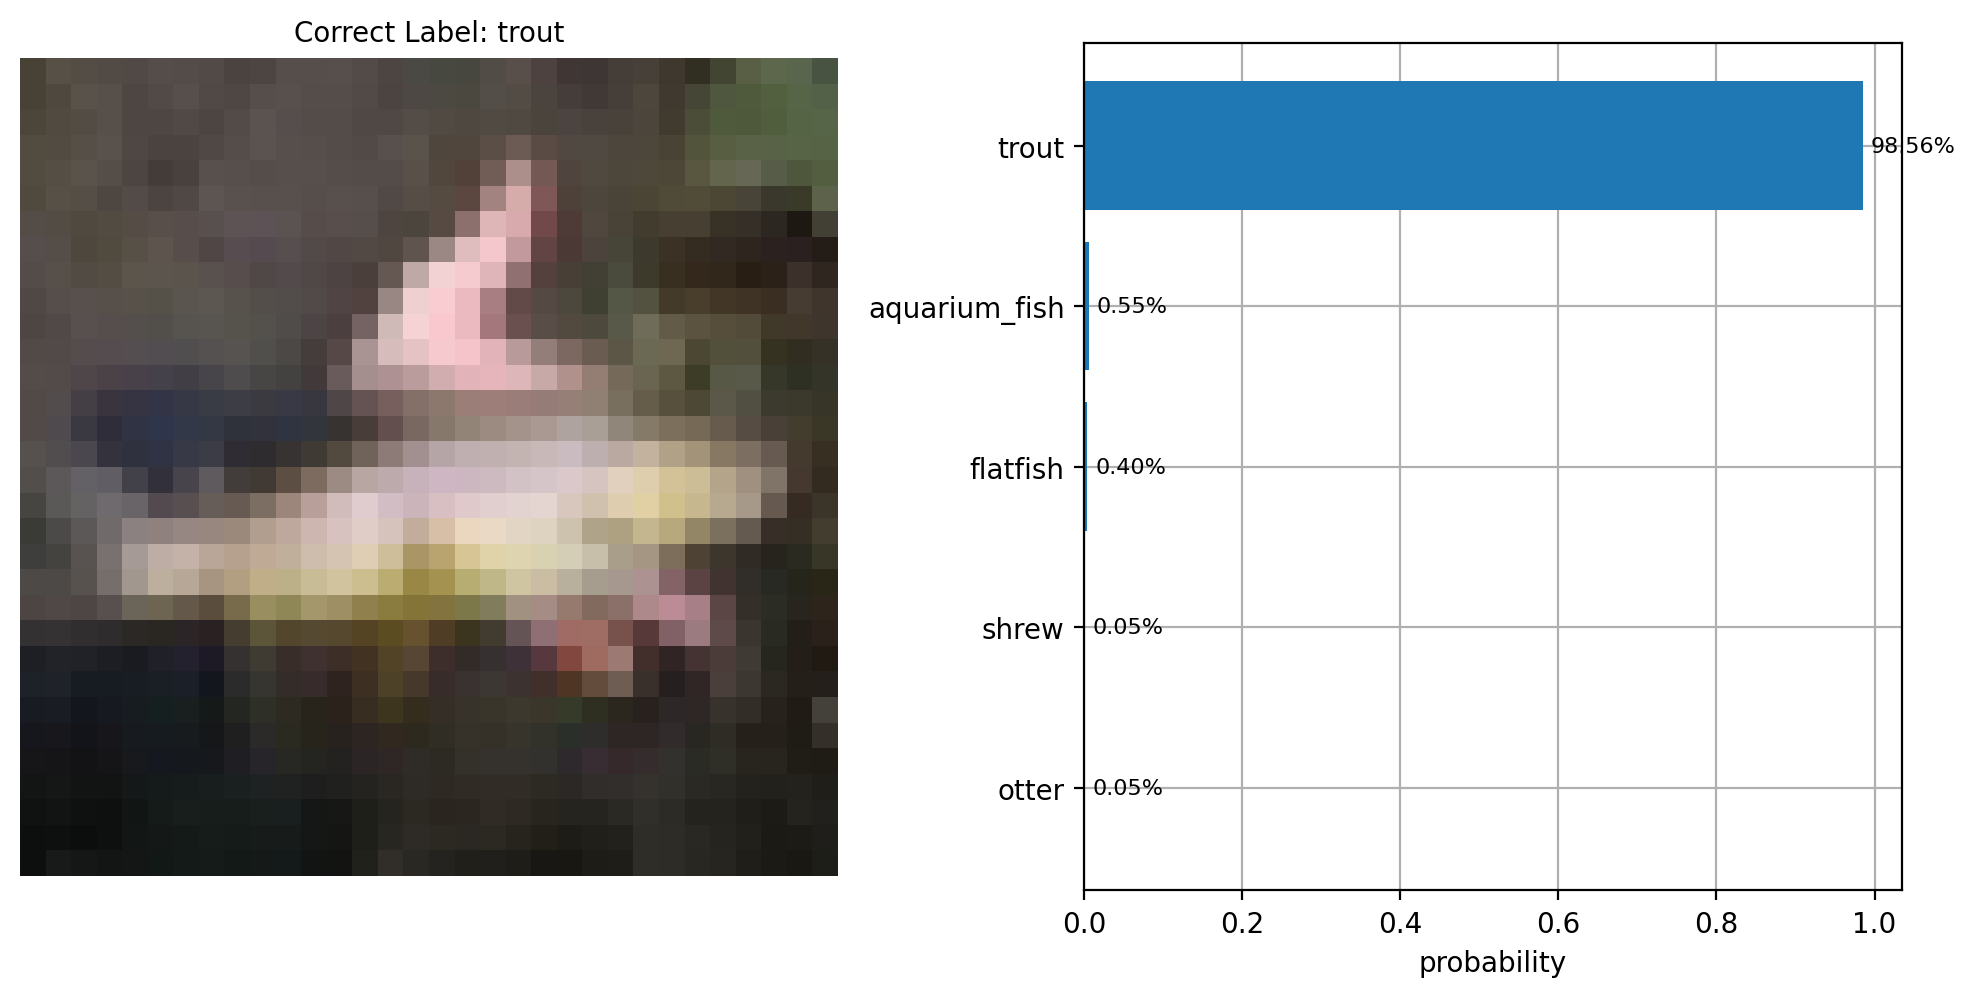

In [112]:
plt.figure(figsize=(10, 5))
img_idx = int(input(f"Please input the index(0-{len(cifar100)}) of image in CIFAR100, which you want to test:"))
image, class_id = cifar100[img_idx]
ax_img = plt.subplot(1, 2, 1)
ax_img.imshow(image)
ax_img.axis("off")
ax_img.set_title(f"Correct Label: {cifar100.classes[class_id]}", fontsize=10)

# predict this image
top_probs, top_labels = predict(image, labels)
# bar chart subplot
ax_bar = plt.subplot(1, 2, 2)
y = np.arange(top_probs.shape[-1])
ax_bar.barh(y, top_probs)
ax_bar.invert_yaxis()
ax_bar.set_axisbelow(True)
ax_bar.set_yticks(y)
ax_bar.set_yticklabels([cifar100.classes[index] for index in top_labels.numpy()])
ax_bar.set_xlabel("probability")
ax_bar.grid(True)
# add percentages on each bar
for j, prob in enumerate(top_probs):
  ax_bar.text(prob + 0.01, j, f"{prob*100:.2f}%", va='center', fontsize=8)

plt.tight_layout()
plt.show()

Please input the index(0-10000) of image in CIFAR100, which you want to test:1254


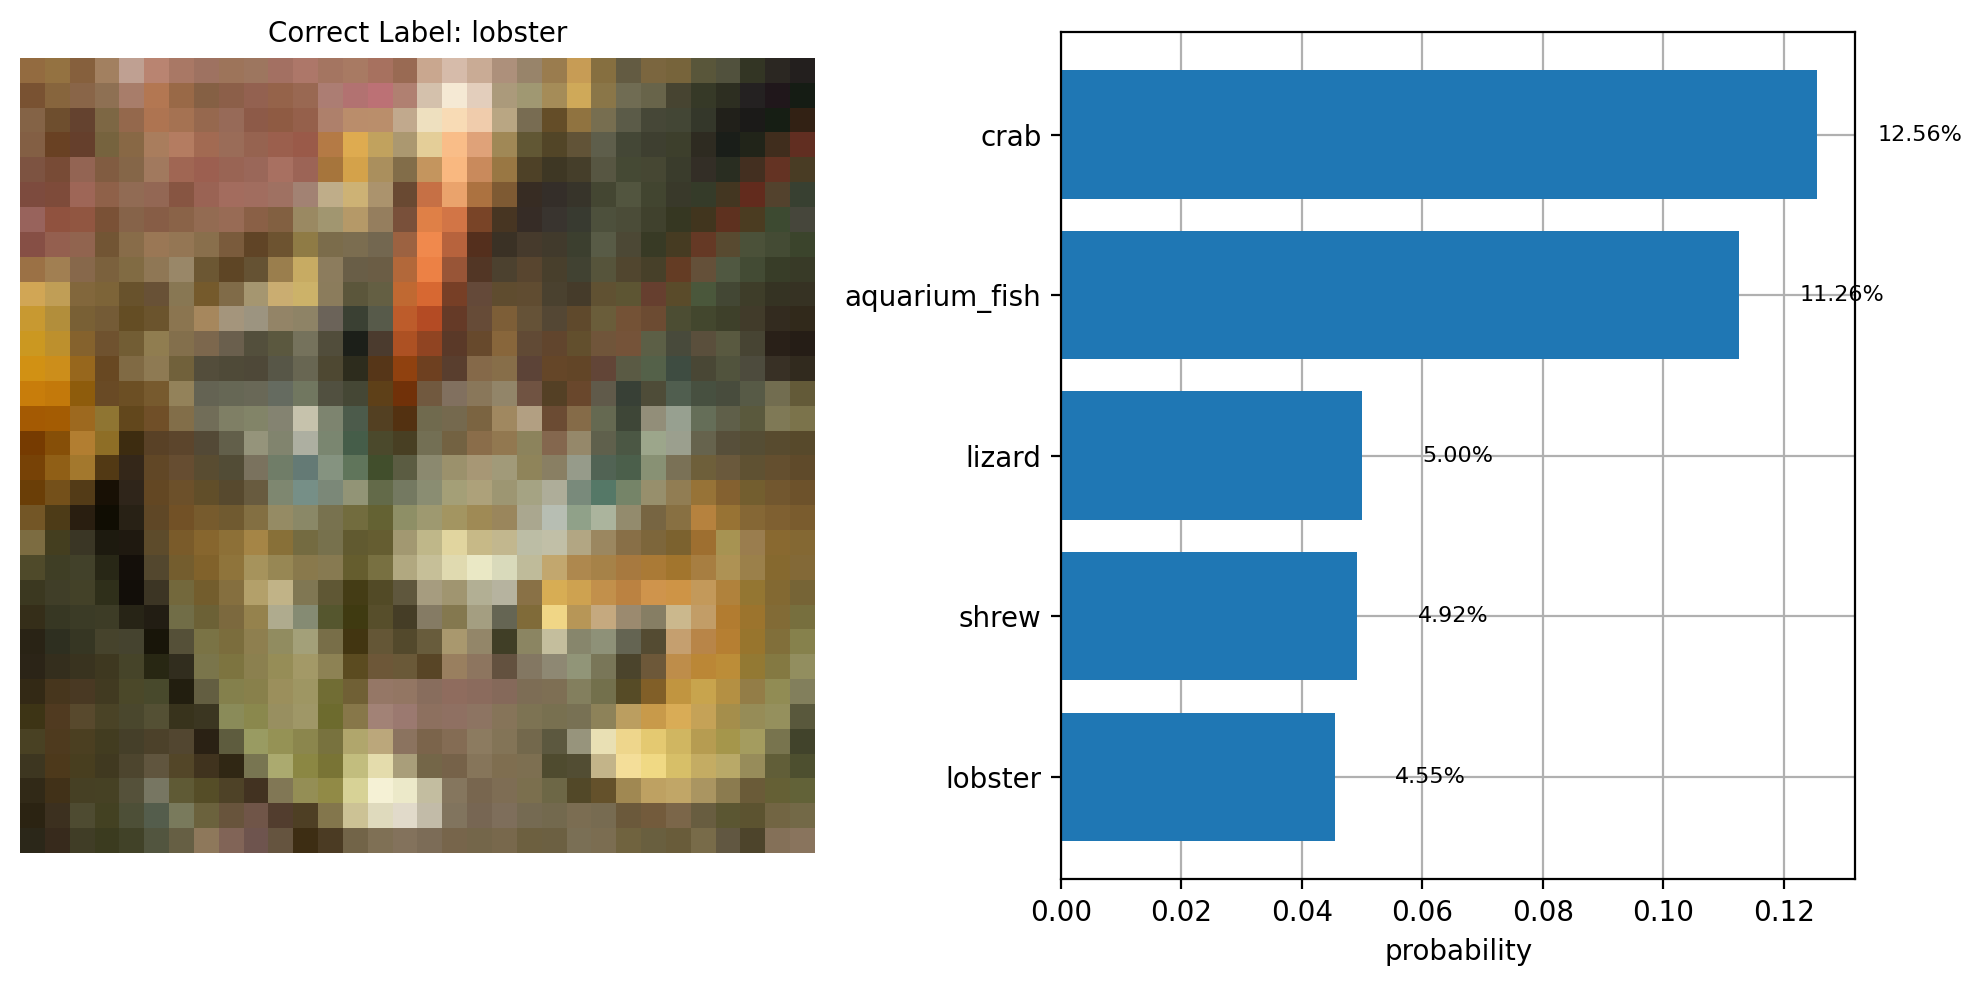

In [113]:
plt.figure(figsize=(10, 5))
img_idx = int(input(f"Please input the index(0-{len(cifar100)}) of image in CIFAR100, which you want to test:"))
image, class_id = cifar100[img_idx]
ax_img = plt.subplot(1, 2, 1)
ax_img.imshow(image)
ax_img.axis("off")
ax_img.set_title(f"Correct Label: {cifar100.classes[class_id]}", fontsize=10)

# predict this image
top_probs, top_labels = predict(image, labels)
# bar chart subplot
ax_bar = plt.subplot(1, 2, 2)
y = np.arange(top_probs.shape[-1])
ax_bar.barh(y, top_probs)
ax_bar.invert_yaxis()
ax_bar.set_axisbelow(True)
ax_bar.set_yticks(y)
ax_bar.set_yticklabels([cifar100.classes[index] for index in top_labels.numpy()])
ax_bar.set_xlabel("probability")
ax_bar.grid(True)
# add percentages on each bar
for j, prob in enumerate(top_probs):
  ax_bar.text(prob + 0.01, j, f"{prob*100:.2f}%", va='center', fontsize=8)

plt.tight_layout()
plt.show()

Please input the index(0-10000) of image in CIFAR100, which you want to test:9999


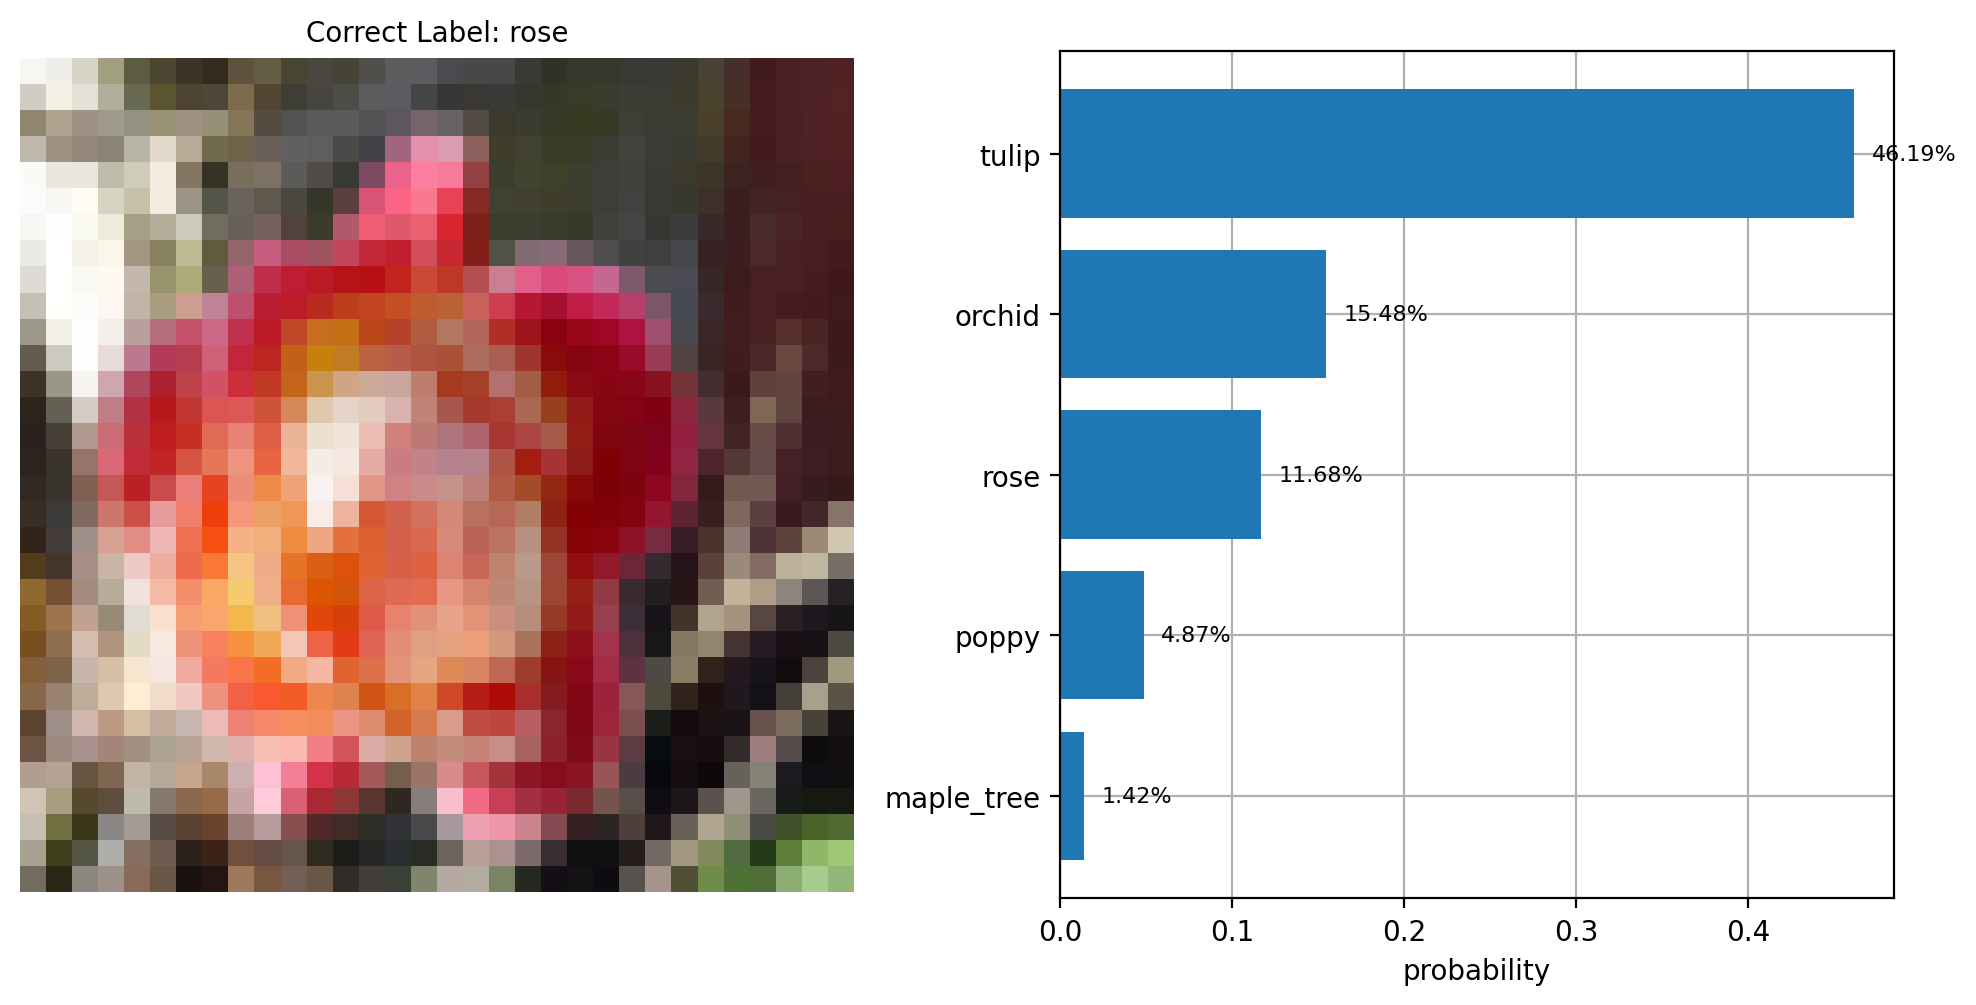

In [114]:
plt.figure(figsize=(10, 5))
img_idx = int(input(f"Please input the index(0-{len(cifar100)}) of image in CIFAR100, which you want to test:"))
image, class_id = cifar100[img_idx]
ax_img = plt.subplot(1, 2, 1)
ax_img.imshow(image)
ax_img.axis("off")
ax_img.set_title(f"Correct Label: {cifar100.classes[class_id]}", fontsize=10)

# predict this image
top_probs, top_labels = predict(image, labels)
# bar chart subplot
ax_bar = plt.subplot(1, 2, 2)
y = np.arange(top_probs.shape[-1])
ax_bar.barh(y, top_probs)
ax_bar.invert_yaxis()
ax_bar.set_axisbelow(True)
ax_bar.set_yticks(y)
ax_bar.set_yticklabels([cifar100.classes[index] for index in top_labels.numpy()])
ax_bar.set_xlabel("probability")
ax_bar.grid(True)
# add percentages on each bar
for j, prob in enumerate(top_probs):
  ax_bar.text(prob + 0.01, j, f"{prob*100:.2f}%", va='center', fontsize=8)

plt.tight_layout()
plt.show()